# Imputation Baselines vs Simulated Missingness

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data.missingness_sim import ID_COLS, MissingnessMechanism, simulate_missingness
from src.data.impute import (
    mean_impute,
    median_impute,
    constant_impute,
)


In [2]:
# Reproducible synthetic dataset with a clear acuity signal for MAR
rng = np.random.default_rng(7)
n = 20000

acuity = rng.integers(1, 6, size=n).astype(float)
severity = 6.0 - acuity  # higher severity when acuity is low

noise = lambda scale: rng.normal(0.0, scale, size=n)

df_true = pd.DataFrame(
    {
        "acuity": acuity,
        "temperature": 98.6 + 0.15 * severity + noise(0.4),
        "heartrate": 72 + 7.0 * severity + noise(4.0),
        "resprate": 16 + 2.2 * severity + noise(1.2),
        "o2sat": 98 - 1.3 * severity + noise(0.7),
        "sbp": 120 - 3.5 * severity + noise(5.0),
        "dbp": 75 - 1.8 * severity + noise(3.0),
    }
)

df_true.describe().T.head()


,count,mean,std,min,25%,50%,75%,max
acuity,20000.0,2.998150,1.419876,1.000000,2.000000,3.000000,4.000000,5.000000
temperature,20000.0,99.050325,0.450898,97.206455,98.741538,99.049413,99.359750,100.780339
heartrate,20000.0,92.985938,10.717516,64.086016,84.166742,92.982218,101.858832,121.836275
resprate,20000.0,22.612585,3.340272,13.814398,19.849558,22.601929,25.382035,31.455862
o2sat,20000.0,94.095646,1.976806,88.813445,92.452345,94.095034,95.724834,99.264832


In [3]:
def apply_mask(data: pd.DataFrame, mask: pd.DataFrame) -> pd.DataFrame:
    # False in the mask means "make missing".
    return data.where(mask)


def masked_mae_rmse(
    df_true: pd.DataFrame,
    df_imputed: pd.DataFrame,
    mask: pd.DataFrame,
    score_cols: list[str],
):
    eligible = df_true[score_cols].notna()
    masked_positions = (~mask[score_cols]) & eligible
    if masked_positions.sum().sum() == 0:
        raise ValueError("No masked positions to score.")

    err = (df_imputed[score_cols] - df_true[score_cols]).where(masked_positions)
    mae = err.abs().stack().mean()
    rmse = np.sqrt((err**2).stack().mean())
    masked_rate = masked_positions.sum().sum() / eligible.sum().sum()
    return float(mae), float(rmse), float(masked_rate)


In [4]:
imputers = {
    "mean": lambda d: mean_impute(d),
    "median": lambda d: median_impute(d),
    "const(0)": lambda d: constant_impute(d, fill_value=0.0),
}

mechanisms = [
    MissingnessMechanism.MCAR,
    MissingnessMechanism.MAR,
    MissingnessMechanism.MNAR,
]

numeric_cols = [
    c for c in df_true.select_dtypes(include=[np.number]).columns if c not in ID_COLS
]
mar_default_score_cols = [c for c in numeric_cols if c != "acuity"]

rate = 0.2
seed = 42

rows = []
for mech in mechanisms:
    mask = simulate_missingness(df_true, mechanism=mech, rate=rate, seed=seed)
    df_miss = apply_mask(df_true, mask)

    # Default MAR does not target acuity, so score only the targeted columns.
    score_cols = mar_default_score_cols if mech is MissingnessMechanism.MAR else numeric_cols

    for name, fn in imputers.items():
        df_imp = fn(df_miss)
        mae, rmse, masked_rate = masked_mae_rmse(
            df_true, df_imp, mask, score_cols=score_cols
        )
        rows.append(
            {
                "mechanism": mech.value,
                "imputer": name,
                "mae": mae,
                "rmse": rmse,
                "masked_rate": masked_rate,
            }
        )

results = pd.DataFrame(rows)
results


,mechanism,imputer,mae,rmse,masked_rate
0,MCAR,mean,3.447378,5.318561,0.199600
1,MCAR,median,3.447474,5.319089,0.199600
2,MCAR,const(0),70.037924,80.025640,0.199600
3,MAR,mean,4.411987,6.470061,0.199608
4,MAR,median,4.523489,6.634162,0.199608
5,MAR,const(0),81.716797,86.604339,0.199608
6,MNAR,mean,4.384557,6.524794,0.199700
7,MNAR,median,4.446038,6.657630,0.199700
8,MNAR,const(0),73.105753,83.051794,0.199700


In [5]:
# Sanity check: masked rate should be close to requested rate
rate_check = (
    results.groupby("mechanism")["masked_rate"].mean().rename("avg_masked_rate")
)
rate_check


mechanism
MAR     0.199608
MCAR    0.199600
MNAR    0.199700
Name: avg_masked_rate, dtype: float64

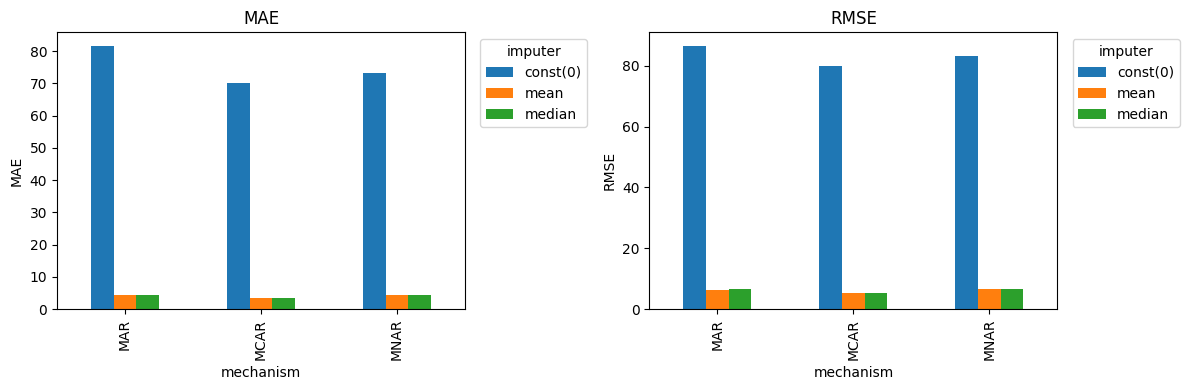

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, metric in zip(axes, ["mae", "rmse"]):
    pivot = results.pivot(index="mechanism", columns="imputer", values=metric)
    pivot.plot(kind="bar", ax=ax)
    ax.set_title(metric.upper())
    ax.set_ylabel(metric.upper())
    ax.legend(title="imputer", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()


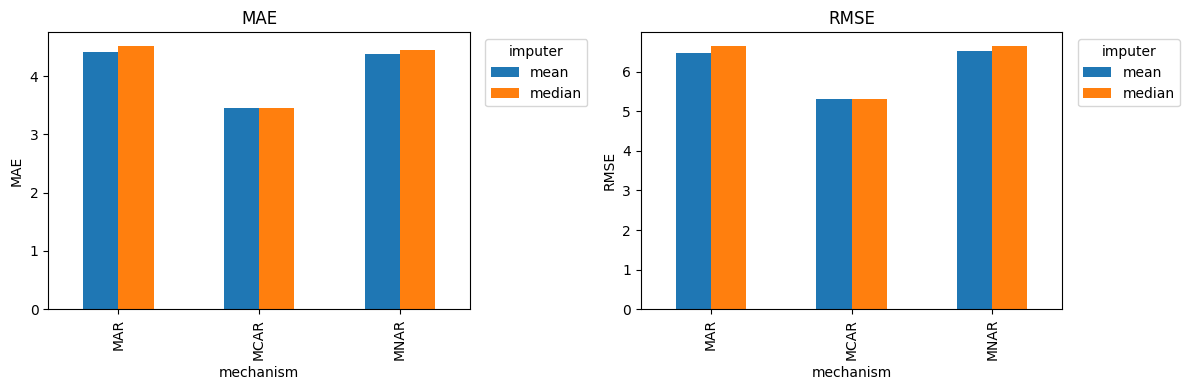

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, metric in zip(axes, ["mae", "rmse"]):
    pivot = results.pivot(index="mechanism", columns="imputer", values=metric)
    pivot = pivot.drop(columns="const(0)")
    pivot.plot(kind="bar", ax=ax)
    ax.set_title(metric.upper())
    ax.set_ylabel(metric.upper())
    ax.legend(title="imputer", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
